# YOU DO NOT NEED TO RUN THE BOX THAT SAYS "generate points.csv"
## That box is only for transforming the points from the raw LIDAR data
## If you accidentally run it, just cancel the process and continue

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import laspy, lazrs
import random as random
import networkx as nx

In [88]:
# generate points.csv | DO NOT NEED TO RUN THIS
x_offset = -12333899.21
y_offset = 4636564.89
z_offset = 1365.4
file_path = os.path.join("data", "point_cloud.laz")
las = laspy.read(file_path)
points = pd.DataFrame(np.vstack((las.x, las.y, las.z)).transpose())
points.columns = ["x", "y", "z"]
for i in range (points.shape[0]):
    points.at[i, "x"] -= x_offset
    points.at[i, "y"] -= y_offset
    points.at[i, "z"] -= z_offset
# points.to_csv("points.csv", index=False)
# z is the height

In [2]:
points = pd.read_csv('points.csv')

In [3]:
res = 10000 # higher res = less points
culled1 = pd.read_csv('points.csv', skiprows=lambda x: x % res != 0)
culled2 = pd.read_csv('points.csv', skiprows=(lambda x: x % res != 2500 and x != 0))
culled3 = pd.read_csv('points.csv', skiprows=(lambda x: x % res != 5000 and x != 0))
culled4 = pd.read_csv('points.csv', skiprows=(lambda x: x % res != 7500 and x != 0))
culled = pd.read_csv('points.csv', skiprows=(lambda x: x % 2500 != 0))

In [4]:
# DON'T RUN THIS
culled1.to_csv("culled1.csv", index=False)
culled2.to_csv("culled2.csv", index=False)
culled3.to_csv("culled3.csv", index=False)
culled4.to_csv("culled4.csv", index=False)
culled.to_csv("culled.csv", index=False)

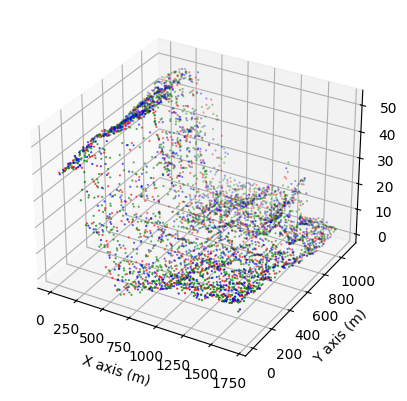

In [5]:
# plot the points
boldness = 0.3
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(culled1["x"], culled1["y"], culled1["z"], c='r', s=boldness)
ax.scatter(culled2["x"], culled2["y"], culled2["z"], c='g', s=boldness)
ax.scatter(culled3["x"], culled3["y"], culled3["z"], c='g', s=boldness)
ax.scatter(culled4["x"], culled4["y"], culled4["z"], c='b', s=boldness)
ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
plt.show()

In [36]:
# generate a random point from the "culled" dataframe
minDistance = 1000
start = culled1.loc[random.randint(0, culled1.shape[0])]
end = culled1.loc[random.randint(0, culled1.shape[0])]

# get the distance between two points
def distance(p1, p2):
    return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2 + (p1.z - p2.z)**2)

while (distance(start, end) < minDistance):
    start_index = random.randint(0, culled1.shape[0])
    end_index = random.randint(0, culled1.shape[0])
    start = culled1.loc[start_index]
    end = culled1.loc[end_index]

# add the points to the other dataframes
culled2.loc[start_index] = start
culled3.loc[start_index] = start
culled4.loc[start_index] = start
culled2.loc[end_index] = end
culled3.loc[end_index] = end
culled4.loc[end_index] = end

print("Start point: ", start["x"], start["y"], start["z"])
print("End point: ", end["x"], end["y"], end["z"])

Start point:  1259.5 888.7000000001863 8.6099999999999
End point:  147.10000000149012 952.1800000006332 47.36999999999989


In [46]:
# Hyperparameters
depth = 4

# heuristic function: greater return value means greater cost for the path (best path has low cost)
def heur(x1, y1, z1, x2, y2, z2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2) * 0.1 * ((z2 - z1) ** 2)
    # return ((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2) * 0.002 * (((z2 - z1) * 0.5) ** 4)

In [47]:
# Graph 1
G1 = nx.Graph()

# Add nodes from the "culled" dataframe
for i, row in culled1.iterrows():
    G1.add_node(i, x=row['x'], y=row['y'], z=row['z'])

# Add edges between the closest nodes
for i, row in culled1.iterrows():
    distances = culled1.apply(lambda r: ((r.x - row.x) ** 2 + (r.y - row.y) ** 2 + (r.z - row.z) ** 2), axis=1)
    closest = distances.nsmallest(depth).index
    for c in closest:
        G1.add_edge(i, c, weight=distances[c])

# Define the heuristic function for A*
def heuristic1(node1, node2):
    x1, y1, z1 = G1.nodes[node1]['x'], G1.nodes[node1]['y'], G1.nodes[node1]['z']
    x2, y2, z2 = G1.nodes[node2]['x'], G1.nodes[node2]['y'], G1.nodes[node2]['z']
    return heur(x1, y1, z1, x2, y2, z2)

# Find the shortest path using A*
path1 = nx.astar_path(G1, start.name, end.name, heuristic=heuristic1)

In [48]:
# Graph 2
G2 = nx.Graph()

# Add nodes from the "culled2" dataframe
for i, row in culled2.iterrows():
    G2.add_node(i, x=row['x'], y=row['y'], z=row['z'])

# Add edges between the closest nodes
for i, row in culled2.iterrows():
    distances = culled2.apply(lambda r: ((r.x - row.x) ** 2 + (r.y - row.y) ** 2 + (r.z - row.z) ** 2), axis=1)
    closest = distances.nsmallest(depth).index
    for c in closest:
        G2.add_edge(i, c, weight=distances[c])

# Define the heuristic function for A*
def heuristic2(node1, node2):
    x1, y1, z1 = G2.nodes[node1]['x'], G2.nodes[node1]['y'], G2.nodes[node1]['z']
    x2, y2, z2 = G2.nodes[node2]['x'], G2.nodes[node2]['y'], G2.nodes[node2]['z']
    return heur(x1, y1, z1, x2, y2, z2)

# Find the shortest path using A*
path2 = nx.astar_path(G2, start.name, end.name, heuristic=heuristic2)

In [49]:
# Graph 3
G3 = nx.Graph()

# Add nodes from the "culled" dataframe
for i, row in culled1.iterrows():
    G3.add_node(i, x=row['x'], y=row['y'], z=row['z'])

# Add edges between the closest nodes
for i, row in culled1.iterrows():
    distances = culled1.apply(lambda r: ((r.x - row.x) ** 2 + (r.y - row.y) ** 2 + (r.z - row.z) ** 2), axis=1)
    closest = distances.nsmallest(depth).index
    for c in closest:
        G3.add_edge(i, c, weight=distances[c])

# Define the heuristic function for A*
def heuristic3(node1, node2):
    x1, y1, z1 = G3.nodes[node1]['x'], G3.nodes[node1]['y'], G3.nodes[node1]['z']
    x2, y2, z2 = G3.nodes[node2]['x'], G3.nodes[node2]['y'], G3.nodes[node2]['z']
    return heur(x1, y1, z1, x2, y2, z2)

# Find the shortest path using A*
path3 = nx.astar_path(G3, start.name, end.name, heuristic=heuristic3)

In [50]:
# Graph 4
G4 = nx.Graph()

# Add nodes from the "culled4" dataframe
for i, row in culled4.iterrows():
    G4.add_node(i, x=row['x'], y=row['y'], z=row['z'])

# Add edges between the closest nodes
for i, row in culled4.iterrows():
    distances = culled4.apply(lambda r: ((r.x - row.x) ** 2 + (r.y - row.y) ** 2 + (r.z - row.z) ** 2), axis=1)
    closest = distances.nsmallest(depth).index
    for c in closest:
        G4.add_edge(i, c, weight=distances[c])

# Define the heuristic function for A*
def heuristic4(node1, node2):
    x1, y1, z1 = G4.nodes[node1]['x'], G4.nodes[node1]['y'], G4.nodes[node1]['z']
    x2, y2, z2 = G4.nodes[node2]['x'], G4.nodes[node2]['y'], G4.nodes[node2]['z']
    return heur(x1, y1, z1, x2, y2, z2)

# Find the shortest path using A*
path4 = nx.astar_path(G4, start.name, end.name, heuristic=heuristic4)

In [51]:
# convert the paths to pandas series
path1 = pd.Series(path1)
path2 = pd.Series(path2)
path3 = pd.Series(path3)
path4 = pd.Series(path4)

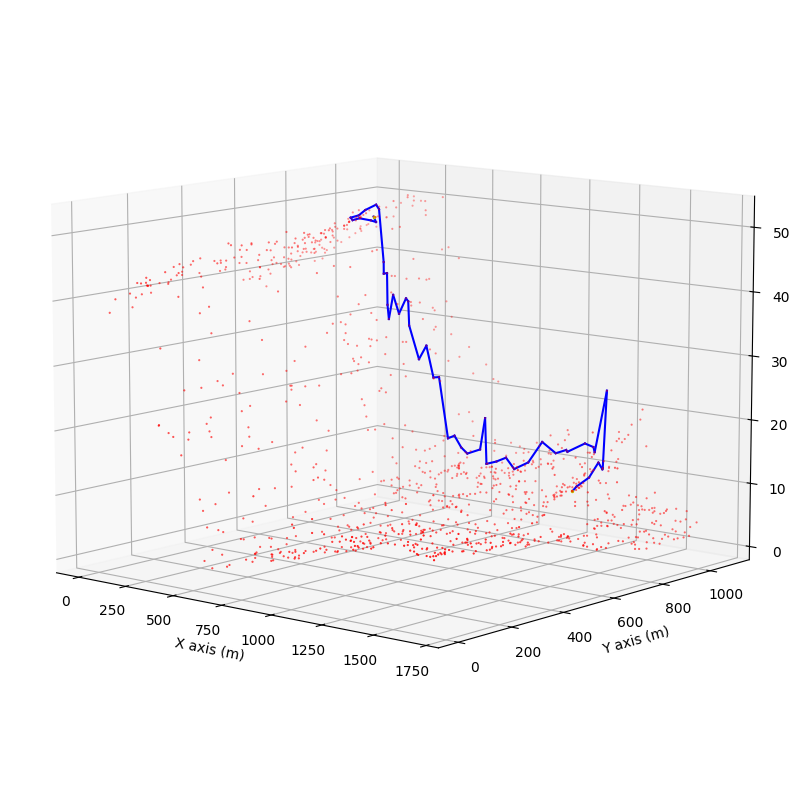

In [55]:
# Plot all of the paths on the same plot
plotSize = 10
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(culled1["x"], culled1["y"], culled1["z"], c='r', s=boldness)
# ax.scatter(culled2["x"], culled2["y"], culled2["z"], c='r', s=boldness)
# ax.scatter(culled3["x"], culled3["y"], culled3["z"], c='r', s=boldness)
ax.scatter(culled4["x"], culled4["y"], culled4["z"], c='r', s=boldness)
ax.scatter(start["x"], start["y"], start["z"], c='y', s=2)
ax.scatter(end["x"], end["y"], end["z"], c='y', s=2)

# for i in range(1, path1.size):
#     p1 = culled1.loc[path1[i-1]]
#     p2 = culled1.loc[path1[i]]
#     ax.plot([p1["x"], p2["x"]], [p1["y"], p2["y"]], [p1["z"], p2["z"]], c='r')
# for i in range(1, path2.size):
#     p1 = culled2.loc[path2[i-1]]
#     p2 = culled2.loc[path2[i]]
#     ax.plot([p1["x"], p2["x"]], [p1["y"], p2["y"]], [p1["z"], p2["z"]], c='g')
# for i in range(1, path3.size):
#     p1 = culled3.loc[path3[i-1]]
#     p2 = culled3.loc[path3[i]]
#     ax.plot([p1["x"], p2["x"]], [p1["y"], p2["y"]], [p1["z"], p2["z"]], c='g')
for i in range(1, path4.size):
    p1 = culled4.loc[path4[i-1]]
    p2 = culled4.loc[path4[i]]
    ax.plot([p1["x"], p2["x"]], [p1["y"], p2["y"]], [p1["z"], p2["z"],], c='b')

ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
# rotate the plot clockwise
ax.view_init(elev=10, azim=-50)

# enlarge the plot
plt.rcParams["figure.figsize"] = (plotSize, plotSize)

plt.show()

In [35]:
# get the set of all points from the 4 paths
all_points = pd.concat([culled1.loc[path1], culled2.loc[path2], culled3.loc[path3], culled4.loc[path4]])
all_points = all_points.drop_duplicates()

# reindex all_points
all_points = all_points.reset_index(drop=True)

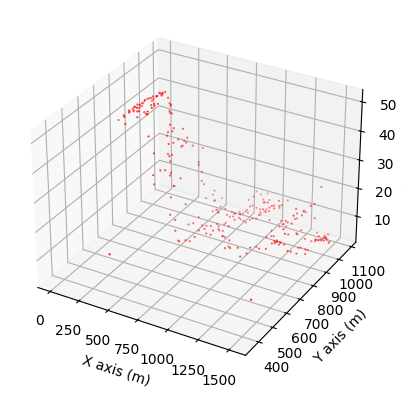

In [19]:
# plot the points from compiled_paths
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(all_points["x"], all_points["y"], all_points["z"], c='r', s=boldness)
ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
plt.show()

In [43]:
# Create a new graph using "all_points"

G = nx.Graph()

# Add nodes from the "all_points" dataframe
for i, row in all_points.iterrows():
    G.add_node(i, x=row['x'], y=row['y'], z=row['z'])

# Add edges between the closest nodes
for i, row in all_points.iterrows():
    distances = all_points.apply(lambda r: ((r.x - row.x) ** 2 + (r.y - row.y) ** 2 + (r.z - row.z) ** 2), axis=1)
    closest = distances.nsmallest(depth).index
    for c in closest:
        G.add_edge(i, c, weight=distances[c])

# Define the heuristic function for A*
def heuristic(node1, node2):
    x1, y1, z1 = G.nodes[node1]['x'], G.nodes[node1]['y'], G.nodes[node1]['z']
    x2, y2, z2 = G.nodes[node2]['x'], G.nodes[node2]['y'], G.nodes[node2]['z']
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)

# Find the shortest path using A*
path = nx.astar_path(G, 0, all_points.shape[0] - 1, heuristic=heuristic)
path = pd.Series(path)

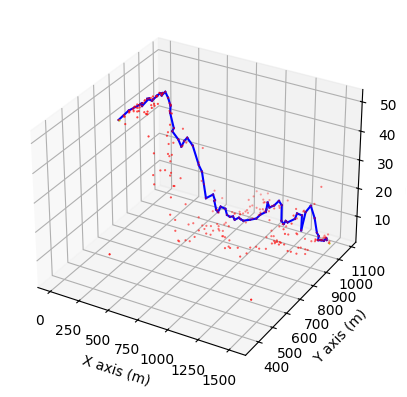

In [45]:
# plot path
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(all_points["x"], all_points["y"], all_points["z"], c='r', s=boldness)
ax.scatter(start["x"], start["y"], start["z"], c='y', s=1)
ax.scatter(end["x"], end["y"], end["z"], c='y', s=1)

for i in range(1, path.size):
    p1 = all_points.loc[path[i-1]]
    p2 = all_points.loc[path[i]]
    ax.plot([p1["x"], p2["x"]], [p1["y"], p2["y"]], [p1["z"], p2["z"]], c='b')

ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
plt.show()

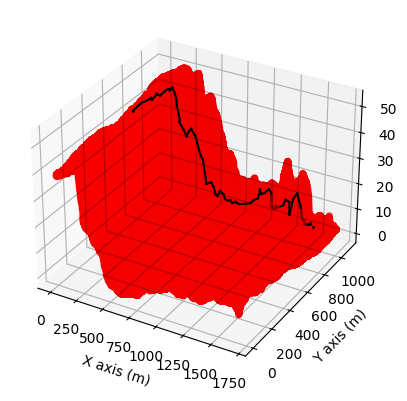

In [51]:
# plot path on the original points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
clr = (1, 0, 0, 0.01)
ax.scatter(points["x"], points["y"], points["z"], c=[clr])
ax.scatter(start["x"], start["y"], start["z"], c='black', s=1)
ax.scatter(end["x"], end["y"], end["z"], c='black', s=1)

for i in range(1, path.size):
    p1 = all_points.loc[path[i-1]]
    p2 = all_points.loc[path[i]]
    ax.plot([p1["x"], p2["x"]], [p1["y"], p2["y"]], [p1["z"], p2["z"]], c='b')

ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
plt.show()